# Imports

In [1]:
import torch
from torch import optim
from tqdm import tqdm
# Imports for this repository
from simplex_generator import simplex_params
from modules import LambdaNetwork, Discriminator, Generator
from gmm_data_generator import load_mixture_of_two_gaussian
from numpy_dataset import NumpyDataset
from md_gan_training import MDGANTraining,gaussian_likelihood_sum

# Parameters

In [2]:
PARAMS = {'batch_size': 500,
          'zdim': 2,
          'gamma':0.5,
          'beta1':0.5,
          'beta2':0.999,
          'n_lr_steps':3,
          'lambda_training_iterations':10001,
          'epochs':2000,
          'eta_lambda': 0.01,
          'e_dim': 9,
          'lr_d': 1e-3,
          'lr_g': 1e-3,
          'epsilon': 1e-8,  # for avoiding numerical instabilities
          'samp_num_gen': 2500}

# Init Simplex and Working Device

In [3]:
working_device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # Find working device
simplex = simplex_params(PARAMS['e_dim'], working_device) # Create Simplex
print("Current Working Device is set to:" + str(working_device))

Current Working Device is set to:cuda


# Search for $\lambda$

In [4]:
lambda_net = LambdaNetwork(PARAMS['e_dim']).to(working_device)
lambda_training_data = torch.tensor([1.0], device=working_device, dtype=torch.float32, requires_grad=False)
optimizer_lambda = optim.Adam(lambda_net.parameters(), lr=PARAMS['eta_lambda'])

for i in tqdm(range(PARAMS['lambda_training_iterations'])):
    optimizer_lambda.zero_grad()
    e = lambda_net(lambda_training_data)
    lambda_lk = gaussian_likelihood_sum(e, simplex)
    lambda_loss = -torch.log(PARAMS['epsilon'] + lambda_lk).mean()
    if i % 1000 == 0 and i > 0:
        print("Lambda Loss:" + str(lambda_loss.item()))
        for group in optimizer_lambda.param_groups:
            group['lr'] = group['lr'] * PARAMS['gamma']
    lambda_loss.backward()
    optimizer_lambda.step()
e = lambda_net(lambda_training_data)
lambda_value = gaussian_likelihood_sum(e, simplex).sum().item()
print(lambda_value)

100%|██████████| 10001/10001 [00:09<00:00, 1000.95it/s]


Lambda Loss:3.812762498855591
Lambda Loss:3.812762498855591
Lambda Loss:3.812762498855591
Lambda Loss:3.812762498855591
Lambda Loss:3.812762498855591
Lambda Loss:3.812762498855591
Lambda Loss:3.812762498855591
Lambda Loss:3.812762498855591
Lambda Loss:3.812762498855591
Lambda Loss:3.812762498855591
0.02208706922829151


# Train Generator and Discriminator

In [5]:
net_g = Generator(PARAMS['zdim']).to(working_device) # Init generator function
net_d = Discriminator(PARAMS['e_dim']).to(working_device) # Init discriminator function
optimizer_g = optim.Adam(net_g.parameters(), lr=PARAMS['lr_g'], betas=(PARAMS['beta1'], PARAMS['beta2']))
optimizer_d = optim.Adam(net_d.parameters(), lr=PARAMS['lr_d'], betas=(PARAMS['beta1'], PARAMS['beta2']))

epoch_step_size=PARAMS['epochs']/(PARAMS['n_lr_steps']+1) # calculate learning rate decay step size
lr_steps=[int((i+1)*epoch_step_size) for i in range(PARAMS['n_lr_steps'])] 
print("Learning rate steps:",lr_steps)
lr_g = optim.lr_scheduler.MultiStepLR(optimizer_g, lr_steps, gamma=PARAMS['gamma'])
lr_d = optim.lr_scheduler.MultiStepLR(optimizer_d, lr_steps, gamma=PARAMS['gamma'])

training_data = load_mixture_of_two_gaussian()
train_dataset = NumpyDataset(training_data)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=PARAMS['batch_size'],
                                           shuffle=True)

md_gan_training=MDGANTraining(net_d, net_g, optimizer_d,optimizer_g,PARAMS['batch_size'], PARAMS['zdim'], simplex,
                     PARAMS['epsilon'],
                     lambda_value,
                     working_device)
# Start Training Loop
for epoch in tqdm(range(PARAMS['epochs'])):
    for d in train_loader:
        d = d.to(working_device)
        md_gan_training.update_discriminator(d)
        md_gan_training.update_generator()

    lr_g.step(epoch) # update Generator learning rate
    lr_d.step(epoch) # update Discriminator learning rate

100%|██████████| 2000/2000 [04:41<00:00,  7.09it/s]


Learning rate steps: [500, 1000, 1500]


# Plot Samples from the Generator

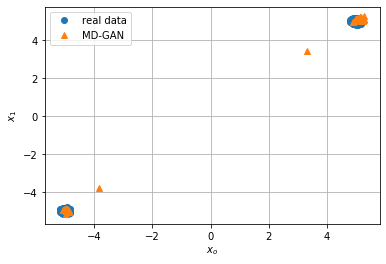

In [6]:
from matplotlib import pyplot as plt

g_samples = net_g(torch.randn(PARAMS['batch_size'], PARAMS['zdim']).to(working_device))
g_samples = g_samples.cpu().detach().numpy()

plt.plot(training_data[:, 0], training_data[:, 1], 'o',label='real data')
plt.plot(g_samples[:, 0], g_samples[:, 1], '^',label='MD-GAN')
plt.legend()
plt.grid()
plt.xlabel(r'$x_o$')
plt.ylabel(r'$x_1$')
plt.savefig('images/gmm_2.png', bbox_inches='tight')
plt.show() 

# Save Generator

In [7]:
torch.save(net_g.state_dict(), 'models/generator_2.pt')
 